# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import os

import sklearn.metrics
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
drive.mount("/content/drive", force_remount=True)
root = "/content/drive/My Drive/Horse Category Classification"
os.chdir(root)
data_root = root + "/data"
data_root_train = data_root + "/train"
data_root_test = data_root + "/test"

Mounted at /content/drive


In [3]:
os.chdir(root+ "/functions")
import modelling

In [22]:
BATCH_SIZE = 32
HEIGHT = 224
WIDTH = 224

# 02 Overfit

In this notebook I am loading the train data and training it for many epochs. I want to see whether I can overfit it to perfect (1.0) F1 Scores. That would mean that the model can perform the basic task. As a model I am using a mobilenet because it is small and adjusted the last layers for my purposes.

In [23]:
class_names=['heavy', 'light', 'pony']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    seed=42,
    subset="training"
)

Found 625 files belonging to 3 classes.
Using 500 files for training.


In [24]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    crop_to_aspect_ratio=False
)

Found 625 files belonging to 3 classes.
Using 125 files for validation.


In [25]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_test,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=False,
)

Found 152 files belonging to 3 classes.


In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
mobileNet = MobileNet(weights='imagenet', include_top=False)
model = modelling.recompile_model(mobileNet, 'rmsprop', 'categorical_crossentropy')

In [28]:
epochs=35
history = model.fit(
  train_ds,
  epochs=epochs
  )

Epoch 1/35
16/16 [==============================] - 7s 128ms/step - loss: 3.5915 - accuracy: 0.4120
Epoch 2/35
16/16 [==============================] - 1s 45ms/step - loss: 1.0815 - accuracy: 0.5560
Epoch 3/35
16/16 [==============================] - 1s 40ms/step - loss: 0.9897 - accuracy: 0.5760
Epoch 4/35
16/16 [==============================] - 1s 40ms/step - loss: 0.8284 - accuracy: 0.6520
Epoch 5/35
16/16 [==============================] - 1s 39ms/step - loss: 0.8042 - accuracy: 0.7000
Epoch 6/35
16/16 [==============================] - 1s 39ms/step - loss: 0.8169 - accuracy: 0.6920
Epoch 7/35
16/16 [==============================] - 1s 39ms/step - loss: 0.6514 - accuracy: 0.7040
Epoch 8/35
16/16 [==============================] - 1s 39ms/step - loss: 0.5925 - accuracy: 0.7540
Epoch 9/35
16/16 [==============================] - 1s 42ms/step - loss: 0.6663 - accuracy: 0.7400
Epoch 10/35
16/16 [==============================] - 1s 44ms/step - loss: 0.4744 - accuracy: 0.8160
Epoch 11

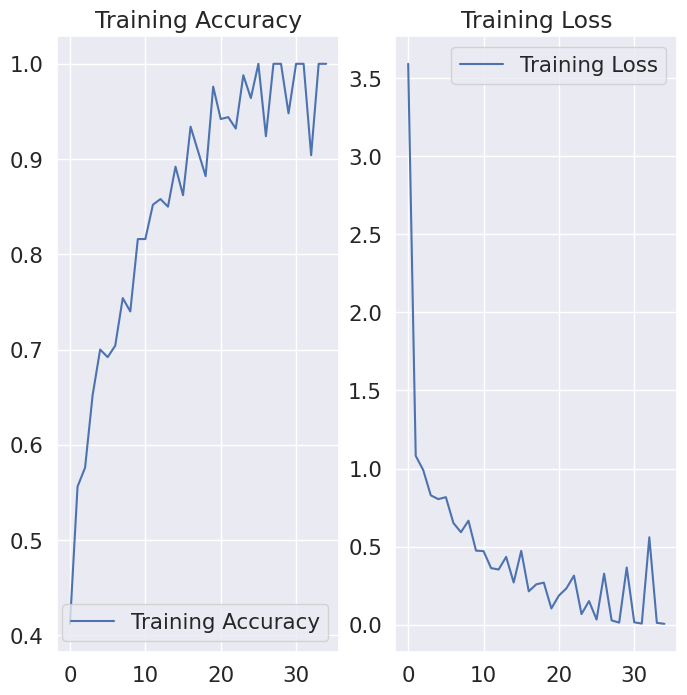

In [29]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [30]:
trainset_predictions = model.predict(train_ds)
train_predicted_labels = [prediction.argmax() for prediction in trainset_predictions]
train_true_labels = modelling.extract_labels_categorical(train_ds)

16/16 [==============================] - 1s 39ms/step


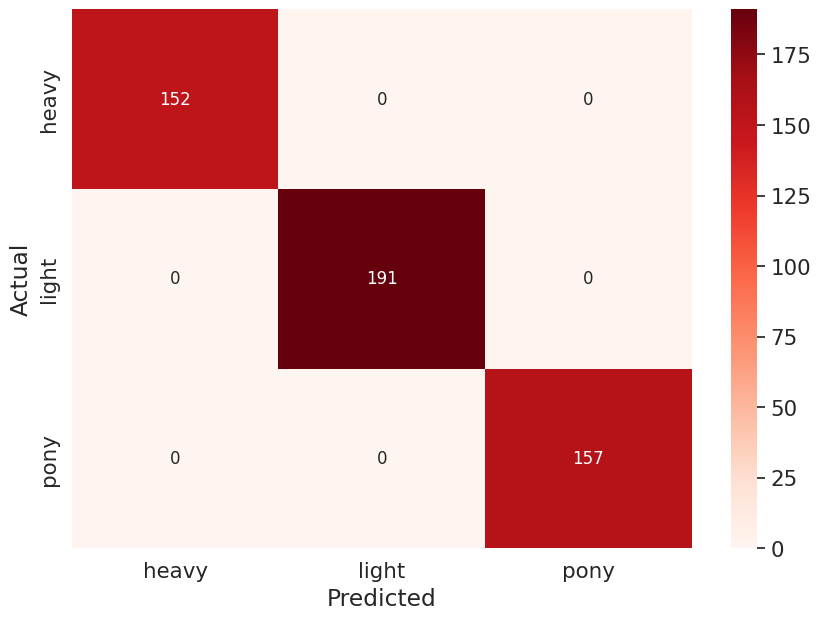

In [31]:
confusion_matrix_train = np.array(tf.math.confusion_matrix(train_true_labels, train_predicted_labels))
confusion_matrix_train = tf.math.confusion_matrix(train_true_labels, train_predicted_labels)
modelling.plot_cm(confusion_matrix_train, class_names)

In [32]:
print(classification_report(train_true_labels,train_predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       152
           1       1.00      1.00      1.00       191
           2       1.00      1.00      1.00       157

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [33]:
valset_predictions = model.predict(val_ds)
val_predicted_labels = [prediction.argmax() for prediction in valset_predictions]
val_true_labels = modelling.extract_labels_categorical(val_ds)

4/4 [==============================] - 1s 34ms/step


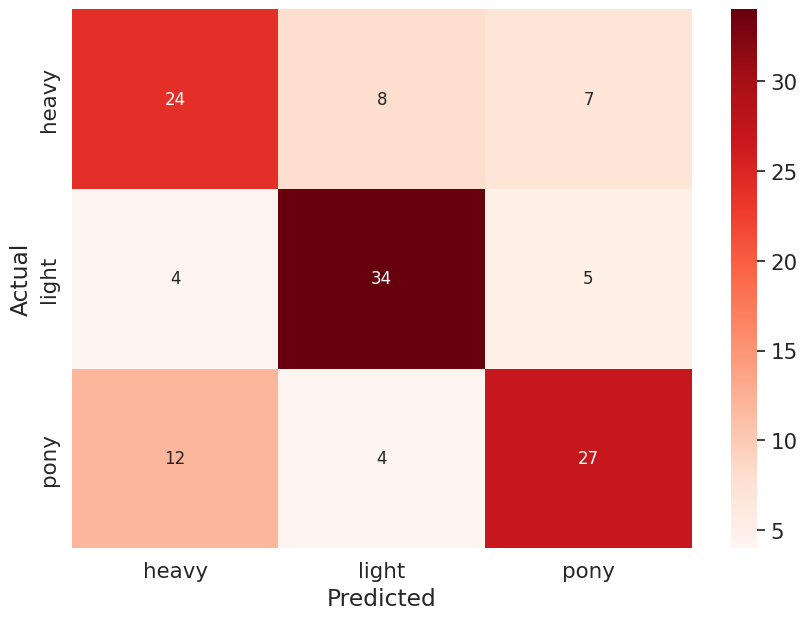

In [34]:
confusion_matrix_val = np.array(tf.math.confusion_matrix(val_true_labels, val_predicted_labels))
confusion_matrix_val = tf.math.confusion_matrix(val_true_labels, val_predicted_labels)
modelling.plot_cm(confusion_matrix_val, class_names)

In [35]:
print(classification_report(val_true_labels,val_predicted_labels))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61        39
           1       0.74      0.79      0.76        43
           2       0.69      0.63      0.66        43

    accuracy                           0.68       125
   macro avg       0.68      0.68      0.68       125
weighted avg       0.68      0.68      0.68       125



In [36]:
testset_predictions = model.predict(test_ds)
test_predicted_labels = [prediction.argmax() for prediction in testset_predictions]
test_true_labels = modelling.extract_labels_categorical(test_ds)

5/5 [==============================] - 1s 97ms/step


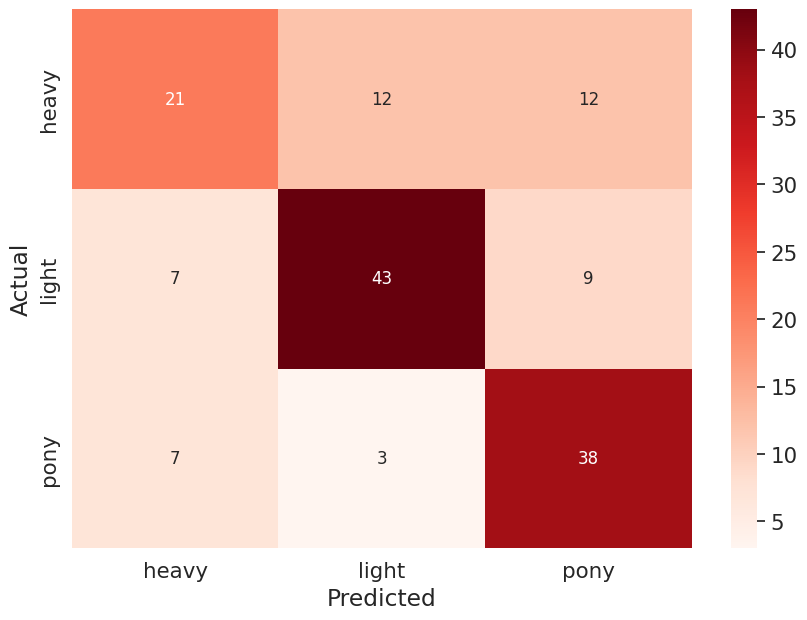

In [37]:
confusion_matrix_test = np.array(tf.math.confusion_matrix(test_true_labels, test_predicted_labels))
confusion_matrix_test = tf.math.confusion_matrix(test_true_labels, test_predicted_labels)
modelling.plot_cm(confusion_matrix_test, class_names)

In [38]:
print(classification_report(test_true_labels,test_predicted_labels))

              precision    recall  f1-score   support

           0       0.60      0.47      0.52        45
           1       0.74      0.73      0.74        59
           2       0.64      0.79      0.71        48

    accuracy                           0.67       152
   macro avg       0.66      0.66      0.66       152
weighted avg       0.67      0.67      0.67       152



# Summary

- I trained the model for 35 epochs and it provided me with the perfect F1 scores for the training.
- The validation and test data performs suprisingly good as well when kept in mind that nothing was done to regularize or improve the pipeline